In [15]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from pytorch_optimizer import Muon
from torch.optim import Adam, SGD


class MLP(nn.Module):
    """
    A multi-layer regression model with specified dimensions and activation function.
    
    Args:
        in_dim (int): Input dimension
        out_dim (int): Output dimension
        hidden_dim (int): Hidden layer dimension
        activation_fn (nn.Module): Activation function to use between layers
        num_layers (int): Number of layers in the network (default: 2)
    """
    def __init__(self, in_dim, out_dim, hidden_dim, activation_fn, num_layers=2, optim_name="SGD"):
        super().__init__()
        self.num_layers = num_layers

        if self.num_layers == 1:
            self.encoder = nn.Linear(in_dim, out_dim, bias=False)
            if optim_name == "SGD":
                self.optimizers = [torch.optim.SGD(self.parameters(), lr=0.0005)]
            elif optim_name == "Spectral":
                self.optimizers = [Muon(self.parameters(), lr=0.0005)]#, weight_decay=0.0, momentum=0.0)]
            else:
                raise ValueError(f"Invalid optimizer name for 1-layer MLP: {optim_name}")
            return
        
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim, bias=False), 
            activation_fn
        )
        
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_layers - 2):
            self.hidden_layers.append(nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim, bias=False),
                activation_fn
            ))

        self.decoder = nn.Linear(hidden_dim, out_dim, bias=False)

        if optim_name == "SGD":
            self.optimizers = [SGD(self.parameters(), lr=0.0005)]
        elif optim_name == "Spectral":
            self.optimizers = [Muon(self.parameters(), lr=0.0005, weight_decay=0.0, momentum=0.0)]
        elif optim_name == "Adam":
            self.optimizers = [Adam(self.parameters(), lr=0.0005)]


    def forward(self, x):
        x = self.encoder(x)
        if self.num_layers == 1: 
            return x
        for layer in self.hidden_layers:
            x = layer(x) + x
        return self.decoder(x)

class LinearOpData(torch.utils.data.Dataset):
    def __init__(self, in_dim, out_dim, X=None):
        self.operator = torch.nn.Linear(in_dim, out_dim, bias=False)
        with torch.no_grad():

            if X is None:
                X = torch.randn(1000, in_dim)
            self.X = X
            self.Y = self.operator(X)

            print("Operator norm (via SVD): ", torch.linalg.svdvals(self.operator.weight.data)[0])
            print("Frobenius norm: ", self.operator.weight.data.norm(p='fro'))

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
def plot_losses(losses):
    """
    Plots the losses over time.
    
    Args:
        losses (list): List of loss values
    """
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.yscale('log')
    plt.grid(True)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')

    # Set x-axis limits
    plt.xlim(0, 10000)

    # Add round numbers for y-axis
    y_ticks = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
    plt.yticks(y_ticks)
    
    plt.show()


Operator norm (via SVD):  tensor(1.0637)
Frobenius norm:  tensor(3.1528)
torch.Size([30]) torch.Size([30])
tensor([ 0.2150, -0.0027, -0.3581,  0.2718, -0.4013,  0.0169, -0.2012, -0.3145,
        -0.3331,  0.0289,  0.3381,  0.2292, -0.0539,  0.1723, -0.0250,  0.1785,
        -0.0412,  0.7209, -0.0859, -0.0388,  0.0637,  0.4916,  0.0435, -0.3073,
         0.0750,  0.3815, -0.1849, -0.4360,  0.4757, -0.1062],
       grad_fn=<SqueezeBackward4>)


Loss: 28.4600:   0%|          | 50/10000 [00:00<00:19, 499.59it/s]

Loss: 81.9261: 100%|██████████| 10000/10000 [00:19<00:00, 514.40it/s]


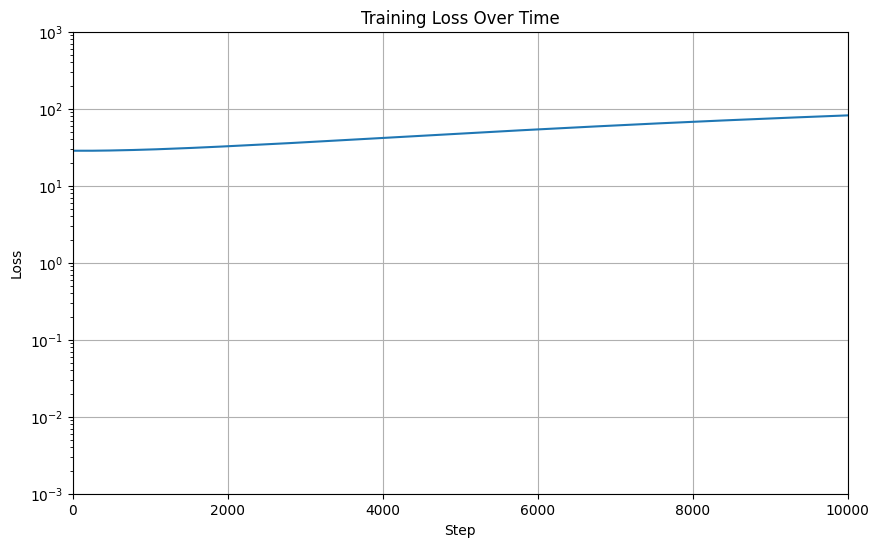

In [16]:
from tqdm import tqdm

d_in  = 30
d_out = 30
d_hidden = 30
n_layers = 2


mlp = MLP(
    in_dim=d_in, 
    out_dim=d_out, 
    hidden_dim=d_hidden, 
    # activation_fn=nn.Identity(), 
    activation_fn=nn.ReLU(),
    num_layers=n_layers,
    # optim_name="SGD"
    optim_name="Spectral"
)

dataset = LinearOpData(in_dim=d_in, out_dim=d_out)

X, Y = dataset[0]
print(X.shape, Y.shape)
print(mlp(X))

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=64, 
    shuffle=False
)
n_steps = 10000; losses = []
for i in (pbar := tqdm(range(n_steps))):
    X, Y = next(iter(dataloader))
    loss = (mlp(X) - Y).norm(p=2).mean()
    loss.backward()
    for optimizer in mlp.optimizers:
        optimizer.step()
    for optimizer in mlp.optimizers:
        optimizer.zero_grad()
    losses.append(loss.item())
    pbar.set_description(f"Loss: {loss.item():.4f}")


plot_losses(losses)